# HAB Capstone Modeling - Final Notebook

This notebook is a more refined version of the explanatory modeling notebook, and will focus more on discussion and explanation of key results. Sections 1 through __ in particular review results of models that were investigated and ultimately rejected for poor performance, and therefore do not show the full code. Sections ___ through are more complete with original code and deeper discussion as these models show more promise. For full modeling details please refer to the HAB_Capstone_Modeling_Exploratory notebook.

## Contents:
[1. Introduction and Data Loading](#1)
 
[2. Linear Regression](#2)
 
[3. Ensemble Methods - Regression, Scaled Features](#3)
* [3.a. Full Feature Data](#3a)
* [3.b. Past Feature Data](#3b)
 
 
[4. Ensemble Methods - Unscaled, Past Features](#4)
* [4.a. Random Forest Regression](#4a)
* [4.b. XGBoost Regression](#4b)
 
[5. Classification with Ensemble Methods](#5)
* [5.a. Random Forest Classification](#5a)
* [5.b. XGBoost Classification](#5b)

In [111]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, recall_score
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, KFold, train_test_split

import xgboost as xgb

import sys
sys.path.append('../src/')
from visualization.visualize import *

## <a id='1'>1. Introduction and Data Loading</a>

The goal of this notebook is to train and test machine learning models for the purpose of predicting harmful algal bloom (HAB) events in the Western Basin of Lake Erie. The problem was first approached as a regression problem to see if we could predict the microcystin concentration at a given location on a given day, then as a classification problem to see if we could predict various classes of microcystin concentration using the Ohio EPA cutoff values:
    <ul>
    <li>drinking limit - 1.6 µg/L</li>
    <li>recreation limit - 6 µg/L</li>
    <li>strict no-contact limit - 20 µg/L</li>
    </ul>
Finally we also performed binary classification to sort samples into low and high microcystin classes using the Ohio EPA recreation limit of 6 µg/L as a cutoff value.

In the exploratory notebook we used both scaled and unscaled features taken from the Great Lakes Environmental Research Laboratory (GLERL). Data were originally sampled with weekly or biweekly frequency depending on the site and year, and have been upsampled to daily frequency with linear interpolation. For the scaled feature set skewed features were first log-transformed and then standardized. Features such as temperature and dissolved oxygen that were not heavily skewed were simply standardized. The final scaled features were then split into training and testing sets with a test size of 0.2. Please see the feature engineering notebook for details. 

In [2]:
#load unscaled data
unscaled = pd.read_csv('../data/processed/unscaled.csv', index_col=0)

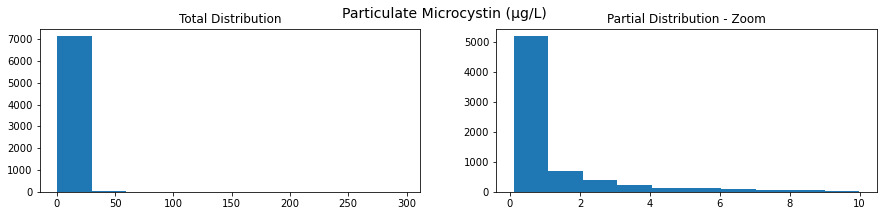

In [3]:
#visualize particulate microcystin distribution
hist_zoom(unscaled, 'Particulate Microcystin (µg/L)', cutoff=10)

In [4]:
print('All Measurements:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 0))
print('Greater than 1.6 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 1.6))
print('Greater than 6 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 6))
print('Greater than 20 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 20))

All Measurements: 7173
Greater than 1.6 µg/L: 1570
Greater than 6 µg/L: 420
Greater than 20 µg/L: 81


As you can see from the histogram, the majority of measurements are between 0 µg/L and 1.6 µg/L. The most extreme cases of particulate microcystin greater than 20 µg/L only constitute 1.1% of all measurements.

## <a id='2'>2. Linear Regression</a>

Our goal is to model future microcystin concentrations using past values, that is, to only use features that could be obtained prior to the predicted day. However, we began modeling using the full feature set to get an idea of how the different models behave and the relative predictive power of the features. Then we will moved on to predictions using restricted feature sets in order to get some idea of the predictive loss when only past features are considered.

Linear regression models using ordinary least squares (OLS), Ridge, and Lasso objective functions were fit to the scaled data. All three models had similar poor performance with mean average errors of approximately 0.5. The models also showed overestimation of low values and underestimation of high values, as expected due to regression to the mean.

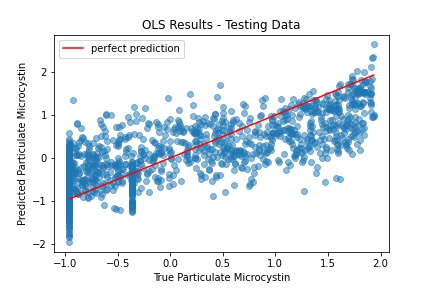

In [12]:
Image(filename='../reports/figures/ols_test_plot.jpg')

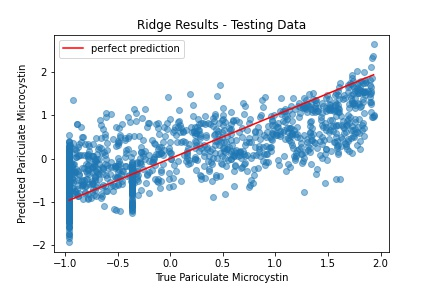

In [13]:
Image(filename='../reports/figures/ridge_test_plot.jpg')

It was clear that linear models are far too underpowered for this problem so we moved on to ensemble methods.

## <a id='3'>3. Ensemble Methods - Regression, Scaled Features</a>
### <a id='3a'> 3.a. Full Feature Data</a>

Random Forest (RF) and XGBoost (XGB) learners were trained on full scaled data and hyperparameter tuning was performed using both random and Bayesian search methods with 3-fold cross validation. Both the RF and XGB learners performed much better than linear methods, with mean average errors of 0.12 and 0.11 on the test set, respectively. 

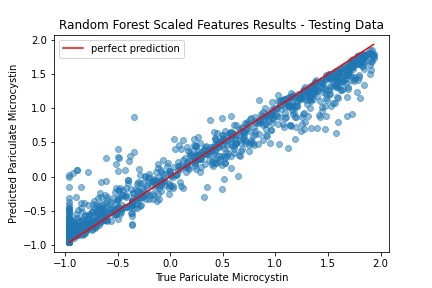

In [14]:
Image(filename='../reports/figures/rf_scaled_plot.jpg')

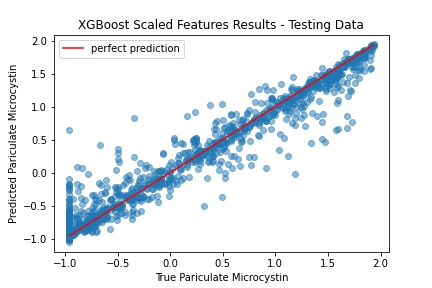

In [15]:
Image(filename='../reports/figures/xgb_scaled_plot.jpg')

### <a id='3b'> 3.a. Past Feature Data</a>

Our goal is to be able to forecast microcystin concentrations based on past nutrient concentrations and environmental data. Therefore we moved on to training models using only features that are obtainable two weeks prior to the desired prediction date. We also removed the site labels to see if we could make reasonable predictions based only on site distance from shore and from the Maumee River inlet.

RF and XGB regression models were again tuned with random search using 3-fold cross-validation. Encouragingly the mean average test error only increased to 0.13 and 0.16 for the RF and XGB models, respectively. This demonstrates that not much predictive power is lost by restricting features to two weeks before the prediction date and earlier. 

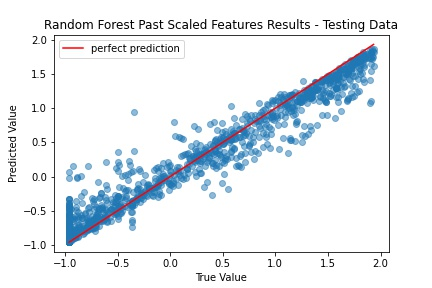

In [16]:
Image(filename='../reports/figures/rfpast_scaled_plot.jpg')

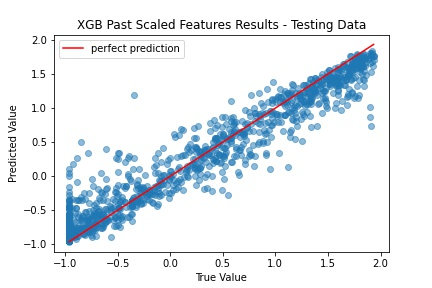

In [17]:
Image(filename='../reports/figures/xgbpast_scaled_plot.jpg')

Since the models are predicting log-transformed microcystin values we needed to transform the data back to its original units to get a better idea of the meaning of the mean average test errors. Both models tend to underestimate high microcystin values and overestimate low microcystin values. The data was transformed back into the original µg/L units to get a better idea of how the model performs for different magnitudes of particulate microcystin concentrations.

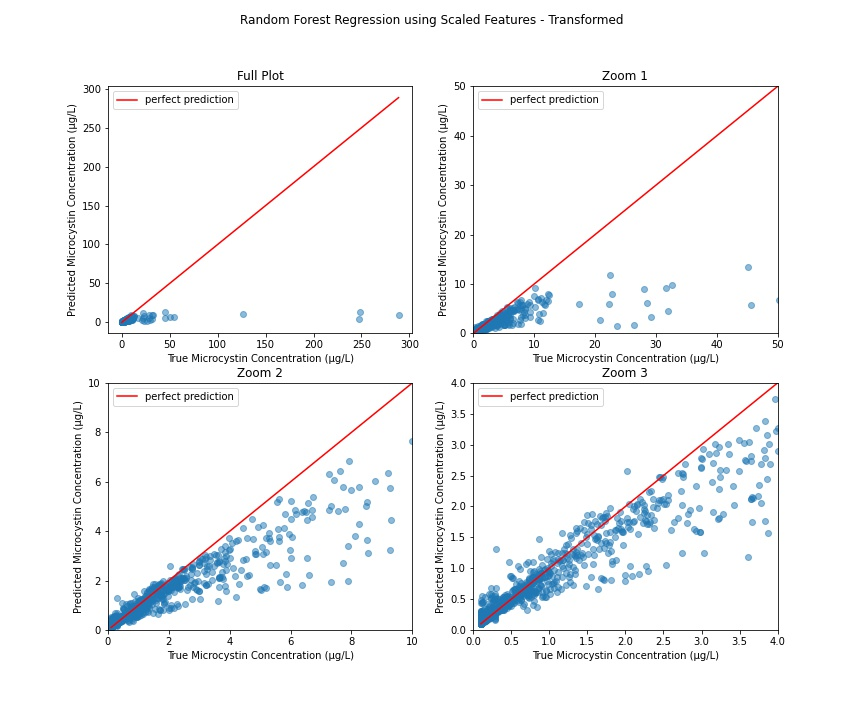

In [20]:
Image(filename='../reports/figures/rf_scaled_unscaled.jpg')

The mean absolute error is 1.2 µg/L for the RF regressor, which is relatively low. However, clearly modeling using scaled features performs fairly well for low microcystin concentrations but quite poorly for high concentrations. This is because on a log scale any given error has a much larger magnitude for large target values than for small, or negative target values. The XGBoost regressor had very similar patterns in error with a mean absolute error of 1.3 µg/L. Since the goal of the project is to really distinguish between regular or low microcystin levels and relatively rare algal bloom events with high microcystin concentrations a model that drastically underestimates high microcystin concentrations is unacceptable. Therefore we turned to working with the original unscaled data.

## <a id='4'>4. Ensemble Methods - Unscaled Past Features</a>
### <a id='4a'>4.a. Random Forest Regression</a>

First we selected unscaled features from two weeks before the target prediction and earlier, and split into training and testing sets. We also remove site labels as features to see if we can make reasonable predictions based only on site distance from shore and from the Maumee River inlet.

In [21]:
#select past features and separate into training and testing split
past_feature_names = ['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11', 
             'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
             'CTD Temperature (°C)_2wks','CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
             'CTD Dissolved Oxygen (mg/L)_2wks', 'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
             'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks',
             'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks','Ammonia (µg N/L)_6wks',
             'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
             'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']
X_unscaled = unscaled[past_feature_names].values
y_unscaled = unscaled['Particulate Microcystin (µg/L)'].values

X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_unscaled, y_unscaled, test_size=0.2)

In [23]:
#perform randomized hyperparameter search on unscaled features
params = {
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rf_us = RandomForestRegressor()
rf_us_cv = RandomizedSearchCV(rf_us, params, cv=3, verbose=1, n_jobs=-1)

rf_us_cv.fit(X_us_train, y_us_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=1)

In [24]:
#examine output
pd.DataFrame(rf_us_cv.cv_results_).sort_values('rank_test_score').T

,0,7,9,5,4,8,1,2,6,3
mean_fit_time,186.207,110.319,61.4363,39.4904,13.6013,30.4794,19.2618,4.59904,18.5251,25.1414
std_fit_time,0.286079,0.42452,0.855186,0.213723,1.77614,1.6183,1.30213,0.101659,3.72141,1.28992
mean_score_time,3.51721,0.6067,0.288529,0.231722,0.10224,0.225515,0.517567,0.12726,0.615551,0.619457
std_score_time,0.13897,0.0133502,0.076915,0.0270285,0.0245047,0.117814,0.0779731,0.0270894,0.111635,0.0405763
param_n_estimators,1000,1000,500,200,100,200,500,200,500,1000
param_min_samples_split,2,4,2,2,4,10,10,2,2,10
param_min_samples_leaf,1,1,4,4,4,1,1,4,4,4
param_max_features,auto,auto,auto,auto,auto,auto,sqrt,sqrt,sqrt,sqrt
param_max_depth,100,10,None,50,10,50,None,10,None,10
params,"{'n_estimators': 1000, 'min_samples_split': 2,...","{'n_estimators': 1000, 'min_samples_split': 4,...","{'n_estimators': 500, 'min_samples_split': 2, ...","{'n_estimators': 200, 'min_samples_split': 2, ...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 500, 'min_samples_split': 10,...","{'n_estimators': 200, 'min_samples_split': 2, ...","{'n_estimators': 500, 'min_samples_split': 2, ...","{'n_estimators': 1000, 'min_samples_split': 10..."


The r-squared coefficient for the best estimator ranges from 0.71 to 0.85 with an average of about 0.80. This estimator may therefore have somewhat variable performance across different data sets.

In [25]:
#fit best estimator and calculate mean absolute error of the training set.
rf_us_best = rf_us_cv.best_estimator_
rf_us_best.fit(X_us_train, y_us_train)
mean_absolute_error(y_us_train, rf_us_best.predict(X_us_train))

0.21870566125025184

In [29]:
def model_test_plot(model, X_test, y_test, name='Model', value='Value', savefig=False, fname='fig'):
    
    """Expects a fitted model. Predicts outputs for a test set and plots predicted values vs true 
    values in a scatterplot. Also returns the mean average prediction error."""
    fig, ax = plt.subplots()
    y_pred = model.predict(X_test)
    x = np.linspace(min(y_test), max(y_test), 50)
    y = x
    ax.plot(x, y, '-r', label='perfect prediction')
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.legend()
    plt.xlabel('True ' + value)
    plt.ylabel('Predicted ' + value)
    plt.title(name + ' Results - Testing Data')
    if savefig:
        fpath = '../reports/figures/' + fname + '.jpg'
        fig.savefig(fpath)
    plt.show()
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

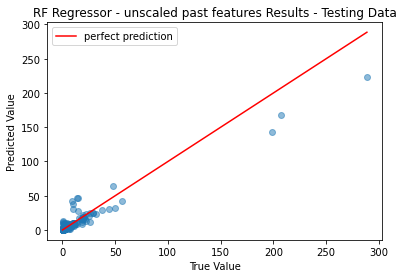

0.6356373751884736

In [36]:
#evaluate RF regressor on unscaled test data
model_test_plot(rf_us_best, X_test=X_us_test, y_test=y_us_test, name='RF Regressor - unscaled past features',
                savefig=True, fname='rf_us_regression')

The RF regressor has an MAE of 0.22 µg/L on the training set and 0.64 µg/L on the test set. This is an encouraging improvement over the scaled feature set, especially considering that only past features were used and site ids were removed. The model still underestimates very high values of microcystin but the performance is more consistent across a range of microcystin values.

### <a id='4a'>4.a. XGBoost Regression</a>

In [31]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

xgbr_us = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             max_delta_step=0, max_depth=6, monotone_constraints='()',
             num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
xgbcv_us = RandomizedSearchCV(xgbr_us, params, cv=3, verbose=1, n_jobs=-1)

xgbcv_us.fit(X_us_train, y_us_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   44.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=None, max_delta_step=0,
                                          max_depth=6, min_child_weight=None,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=None,
                                          nu...
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weight=1, subsample=1,
   

In [32]:
#examine random search results
pd.DataFrame(xgbcv_us.cv_results_).sort_values('rank_test_score').T

,0,5,7,6,8,9,3,1,2,4
mean_fit_time,7.06857,17.7343,0.452119,0.749416,1.58338,24.1672,5.35718,3.18905,3.59412,2.17791
std_fit_time,0.0915505,0.631856,0.034555,0.0400954,0.0793572,1.63615,0.205784,0.520657,0.0150618,0.248529
mean_score_time,0.0240727,0.0291781,0.0068903,0.00912333,0.0174642,0.047345,0.0260473,0.0179103,0.0190486,0.015601
std_score_time,0.00286821,0.007997,0.000112686,0.00389201,0.0120386,0.0109354,0.010285,0.00444034,0.00296243,0.00821295
param_n_estimators,50,100,10,10,20,100,100,20,50,20
param_min_child_weight,0.5,0.5,1,0.5,1,5,0.5,3,5,5
param_max_depth,50,100,10,10,10,50,None,100,None,100
param_learning_rate,0.2,0.2,0.3,0.3,0.1,0.2,0.01,0.01,0.001,0.001
param_gamma,0.5,1,0,0,0,1,0.5,0.5,0,1
param_colsample_bytree,0.5,0.7,0.5,0.8,0.9,1,0.9,0.9,1,0.8


The xgboost estimator is a bit more consistent across cross-validation sets than the random forest estimator with a mean test score of 0.85 and a standard deviation of 0.03.

In [34]:
xgbus_best = xgbcv_us.best_estimator_
xgbus_best.fit(X_us_train, y_us_train)
mean_absolute_error(y_us_train, xgbus_best.predict(X_us_train))

0.0702966684770694

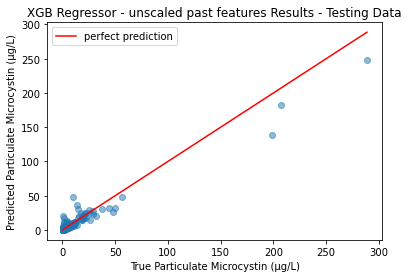

0.5504658983819337

In [37]:
model_test_plot(xgbus_best, X_us_test, y_us_test, name='XGB Regressor - unscaled past features', 
                value='Particulate Microcystin (µg/L)', savefig=True, fname='xgb_us_regression')

Again the XGBoost model performs slightly better than the Random Forest regressor with a mean absolute error of 0.55 µg/L versus 0.64 µg/L on the test set. We can get a better look at the model performance by zooming in on the test plot.

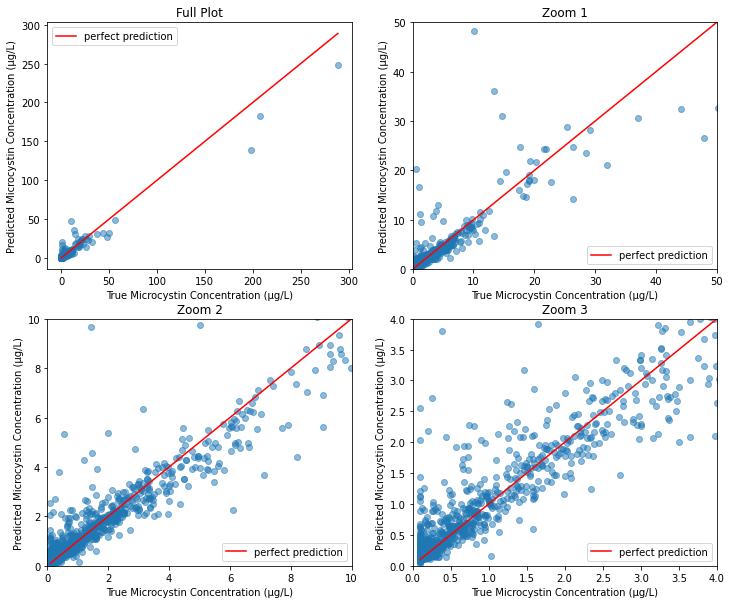

In [39]:
y_usxgb_pred = xgbus_best.predict(X_us_test)

x = np.linspace(min(y_us_test), max(y_us_test), 50)
y = x
fig, ax = plt.subplots(2,2, figsize=(12,10))
for i in range(2):
    for j in range(2):
        ax[i, j].plot(x, y, '-r', label='perfect prediction')
        ax[i, j].scatter(y_us_test, y_usxgb_pred, alpha=0.5)
        ax[i,j].legend()
        ax[i, j].set_xlabel('True Microcystin Concentration (µg/L)')
        ax[i, j].set_ylabel('Predicted Microcystin Concentration (µg/L)')
        #ax[i, j].set_title('Random Forest Unscaled Past Features Results - Testing Data')
        
ax[0,0].set_title('Full Plot')
        
ax[0,1].set_xlim(0,50)
ax[0,1].set_ylim(0,50)
ax[0,1].set_title('Zoom 1')

ax[1,0].set_xlim(0,10)
ax[1,0].set_ylim(0,10)
ax[1,0].set_title('Zoom 2')

ax[1,1].set_xlim(0,4)
ax[1,1].set_ylim(0,4)
ax[1,1].set_title('Zoom 3')

fig.savefig('../reports/figures/xgb_us_regression_zoom.jpg')

plt.show()

The model on average performs quite well for low microcystin concentrations, but there are a handful of values with true concentrations over 6 µg/L whose concentrations are quite underestimated. This is logical from a machine learning perspective - most of the data has low microcystin concentrations, so more accurate treatment of this region is incentivized during training. However, our goals pertain more to accurate identification and prediction of high concentration samples. While it would be nice to have a prediction that estimates exact microcystin concentration it may be better to approach this as a classification problem. From an application and policy standpoint the response to a concentration of 8 µg/L versus 6 µg/L is much the same, what is really important is predicting where a sample will fall in the spectrum of EPA concentration categories.

## <a id='5'>5. Classification with Ensemble Methods</a>
### <a id='5a'>5.a. Random Forest Classification</a>

We start with a multiclass approach by attempting to predict whether microcystin concentrations will be low (i.e. below Ohio EPA drinking limit of 1.6 µg/L), medium (i.e. below Ohio EPA recreational limit of 6µg/L), or high (i.e. above Ohio EPA strict no-contact limit of 20µg/L). We will only use unscaled features and ensemble methods here.

In [49]:
#define function for sorting particulate microcystin concentrations into categories
def pm_cat(pm):
    if pm < 1.6:
        return 0
    elif pm < 6:
        return 1
    elif pm < 20:
        return 2
    else:
        return 3

unscaled['Particulate Microcystin Category'] = unscaled['Particulate Microcystin (µg/L)'].apply(lambda x: pm_cat(x))
unscaled[['Particulate Microcystin Category','Particulate Microcystin (µg/L)']].sample(5)

,Particulate Microcystin Category,Particulate Microcystin (µg/L)
Date,,
2014-07-20,1,3.277143
2013-06-20,0,0.100000
2017-07-29,0,1.228571
2017-08-27,1,2.074286
2017-08-12,1,2.897143


In [50]:
#check out category distributions
unscaled['Particulate Microcystin Category'].value_counts()

0    5603
1    1150
2     339
3      81
Name: Particulate Microcystin Category, dtype: int64

The classes are fairly imbalanced so we will use balanced accuracy as a scoring metric to incentivize identifying higher particulate microcystin samples.

In [51]:
#split into training and testing sets, this time with a test size of 0.3 to increase likelihood that high 
#microcystin classes are well-represented 
y_cat = unscaled['Particulate Microcystin Category'].values
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_unscaled, y_cat, test_size=0.3)

In [52]:
#perform randomized hyperparameter search on unscaled features
params = {
 'max_depth': [None, 10, 50, 100],
 'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rfcat = RandomForestClassifier()
rfcat_cv = RandomizedSearchCV(rfcat, params, cv=3, verbose=1, n_jobs=-1, scoring='balanced_accuracy')

rfcat_cv.fit(X_cat_train, y_cat_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   scoring='balanced_accuracy', verbose=1)

In [53]:
pd.DataFrame(rfcat_cv.cv_results_).sort_values('rank_test_score').T

,2,9,3,7,5,4,0,1,8,6
mean_fit_time,4.52727,22.6516,17.9059,28.657,4.83639,4.41416,18.3982,17.0737,2.48355,22.7416
std_fit_time,0.161741,4.52083,0.14422,3.91364,0.0839104,0.202415,0.0644255,0.69225,0.440415,0.0700205
mean_score_time,0.170005,0.869553,0.437267,1.61388,0.206208,0.185545,0.418779,0.465065,0.233146,0.794699
std_score_time,0.014282,0.451224,0.0629632,0.610816,0.0146816,0.0189966,0.0320318,0.0891776,0.154178,0.0218732
param_n_estimators,200,500,500,1000,200,200,500,500,100,1000
param_min_samples_split,2,2,10,10,10,10,2,10,2,2
param_min_samples_leaf,1,1,1,1,1,1,4,4,4,4
param_max_features,sqrt,auto,auto,sqrt,sqrt,sqrt,auto,auto,auto,auto
param_max_depth,50,None,50,100,50,100,100,100,100,100
param_criterion,gini,entropy,entropy,gini,gini,gini,entropy,entropy,gini,gini


The classifier seems to have more consistent treatment across different cross-validation sets than the regressor.

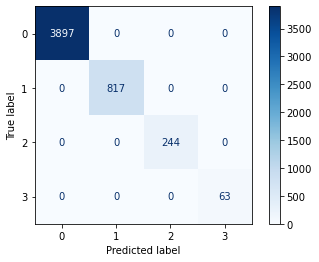

In [54]:
rfcat_best = rfcat_cv.best_estimator_
rfcat_best.fit(X_cat_train, y_cat_train)
plot_confusion_matrix(rfcat_best, X_cat_train, y_cat_train, cmap='Blues')
plt.show()

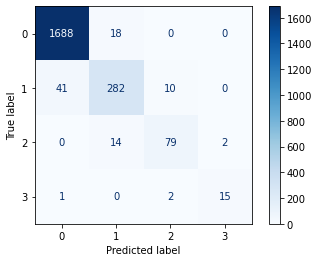

In [55]:
#test set confusion matrix
plot_confusion_matrix(rfcat_best, X_cat_test, y_cat_test, cmap='Blues')
plt.show()

In [58]:
pd.DataFrame(precision_recall_fscore_support(y_cat_test, rfcat_best.predict(X_cat_test)), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1,2,3
Precision,0.975723,0.898089,0.868132,0.882353
Recall,0.989449,0.846847,0.831579,0.833333
Fscore,0.982538,0.871716,0.849462,0.857143
Support,1706.000000,333.000000,95.000000,18.000000


For the most part the random forest correctly identifies the class or incorrectly labels a sample as being in a member of an adjacent class, usually the next lowest microcystin level. A total of 1 / 1435 samples were labeled as being more than one class away from the correct label. The recall for non-low microcystin concentrations is about 0.83. Recall is the most notable metric for our application since our goal is to identify all HAB events. A false-positive event is an annoyance, but not predicting a bloom that then happens is more detrimental.

### <a id='5b'>5.b. XGBoost Classification</a>

In [60]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1],
    'objective': ['binary:logistic', 'multi:softmax'],
    'num_class': [4]
}

xgbcat = xgb.XGBClassifier()
xgbcat_cv = RandomizedSearchCV(xgbcat, params, cv=3, verbose=1, n_jobs=-1, scoring='balanced_accuracy')
xgbcat_cv.fit(X_cat_train, y_cat_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           verbosity=None),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.8, 0.9,
          

In [61]:
#examine cv results
pd.DataFrame(xgbcat_cv.cv_results_).sort_values('rank_test_score').T

,9,1,0,6,5,7,8,2,3,4
mean_fit_time,12.5148,4.03759,3.06549,5.34153,3.15309,2.80642,3.70379,6.52873,1.7221,26.0284
std_fit_time,0.583346,0.223033,0.0325767,0.250801,0.193027,0.239278,0.116368,0.296492,0.193427,0.190775
mean_score_time,0.0979977,0.0364474,0.0325847,0.0427051,0.0463867,0.045978,0.025449,0.0348529,0.0400416,0.163805
std_score_time,0.01232,0.00841703,0.00515898,0.00559662,0.0135787,0.0109457,0.00577003,0.00839684,0.00826171,0.0390161
param_objective,binary:logistic,binary:logistic,multi:softmax,multi:softmax,multi:softmax,multi:softmax,multi:softmax,multi:softmax,binary:logistic,multi:softmax
param_num_class,4,4,4,4,4,4,4,4,4,4
param_n_estimators,100,20,20,20,20,10,10,20,10,100
param_min_child_weight,0.5,3,5,1,0.5,1,5,1,3,3
param_max_depth,None,10,100,50,10,10,100,50,100,50
param_learning_rate,0.2,0.2,0.3,0.2,0.1,0.2,0.3,0.001,0.001,0.001


The xgboost classifier has a slightly lower balanced accuracy than the random forest classifier and a slightly higher standard deviation in the test score.

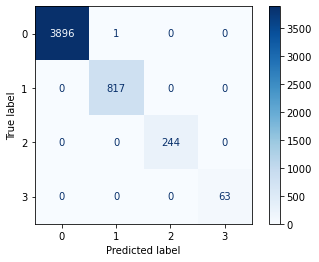

In [62]:
xgbcat_best = xgbcat_cv.best_estimator_
xgbcat_best.fit(X_cat_train, y_cat_train)
plot_confusion_matrix(xgbcat_best, X_cat_train, y_cat_train, cmap='Blues')
plt.show()

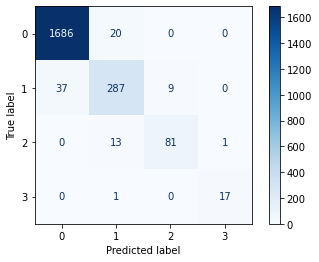

In [63]:
plot_confusion_matrix(xgbcat_best, X_cat_test, y_cat_test, cmap='Blues')
plt.show()

In [64]:
pd.DataFrame(precision_recall_fscore_support(y_cat_test, xgbcat_best.predict(X_cat_test)), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1,2,3
Precision,0.978526,0.894081,0.900000,0.944444
Recall,0.988277,0.861862,0.852632,0.944444
Fscore,0.983377,0.877676,0.875676,0.944444
Support,1706.000000,333.000000,95.000000,18.000000


On this particular test set the xgboost classifier performed much better than the random forest with a recall of 0.85 to 0.94 for higher microcystin classes. There does seem to be some question of variability of performance for both estimators. We can get a better estimate of performance across datasets by doing a full five-fold cross-validation using macroscopic recall as the score so that high concentration microcystin classes are equally weighted.

In [141]:
#recall scores for rf with 5-fold cross validation on full data set 
cross_val_score(rfcat_best, X_unscaled, y=y_cat, cv=5, scoring='recall_macro')

array([0.4621361 , 0.39935233, 0.47855604, 0.37505252, 0.3288249 ])

In [137]:
#recall scores for xgb with 5-fold cross validation on full data set 
cross_val_score(xgbcat_best, X_unscaled, y=y_cat, cv=5, scoring='recall_macro')

array([0.42076693, 0.41748461, 0.46970285, 0.38102907, 0.32707173])

In [138]:
#for some reason scores on the full data set with 5-fold cross validation are quite low? 
#But if only using the training set...
cross_val_score(rfcat_best, X_cat_train, y=y_cat_train, cv=5, scoring='recall_macro')


array([0.88951225, 0.8556358 , 0.85813562, 0.89069254, 0.86564434])

In [139]:
#something strange is happening here and I'm not sure why or how.
cross_val_score(xgbcat_best, X_cat_train, y=y_cat_train, cv=5, scoring='recall_macro')

array([0.89453406, 0.84289635, 0.84389798, 0.83303565, 0.84608802])

In [142]:
#Was there something serendipitously nice about the original training set?
#Let's look at five different train / test splits
rscores = []
for i in range(20):
    X_tr, X_te, y_tr, y_te = train_test_split(X_unscaled, y_cat, test_size=0.2)
    xgbcat_best.fit(X_tr, y_tr)
    y_pr = xgbcat_best.predict(X_te)
    rs = recall_score(y_te, y_pr, average='macro', zero_division=1)
    rscores.append(rs)
print(rscores)

[0.9226656854299107, 0.8930160764212488, 0.8964680836569248, 0.8722638266300009, 0.8720459198172023, 0.8525323005961674, 0.8992962313091242, 0.9285450313412418, 0.8802605117620597, 0.9064447595601018, 0.841590996197248, 0.8811583951751277, 0.8859750047630005, 0.8585624385447395, 0.8104023776535144, 0.8673548510313216, 0.9061252537597144, 0.8867426204899304, 0.9136993160217204, 0.8224138891322322]


In [140]:
#Compare with k-fold (this should basically be a manual cross validation?)
kf = KFold(n_splits=5)
rscores = []
for tr_i, te_i in kf.split(X_unscaled):
    X_tr, X_te = X_unscaled[tr_i], X_unscaled[te_i]
    y_tr, y_te = y_cat[tr_i], y_cat[te_i]
    xgbcat_best.fit(X_tr, y_tr)
    y_pr = xgbcat_best.predict(X_te)
    rs = recall_score(y_te, y_pr, average='macro', zero_division=1)
    rscores.append(rs)
print(rscores)

[0.4529460731221825, 0.2838535111753832, 0.3963019024117788, 0.6809923376095663, 0.42569691632111356]


I am somewhat stumped as to why the cross-validation and k-fold scores are so different than doing a regular train/test split with a test size of 0.2. I understand that with cross-validation the entire data set is used in training and testing at some point, whereas with random train / test selections that is not assured. However there is a fairly large difference in the scores here that doesn't seem like it could be due to that chance. None of the train/test scores are as low as any of the kfold/crossval scores, and none of the crossval/kscores are as high as the train/test scores. I must be missing something or maybe I've done something silly here.